In [20]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

In [21]:
img = Image.open("examples/input.png")

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

Using cpu


In [13]:
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

In [14]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [15]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [16]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [17]:
import matplotlib.pyplot as plt

Using grad_attention_rollout


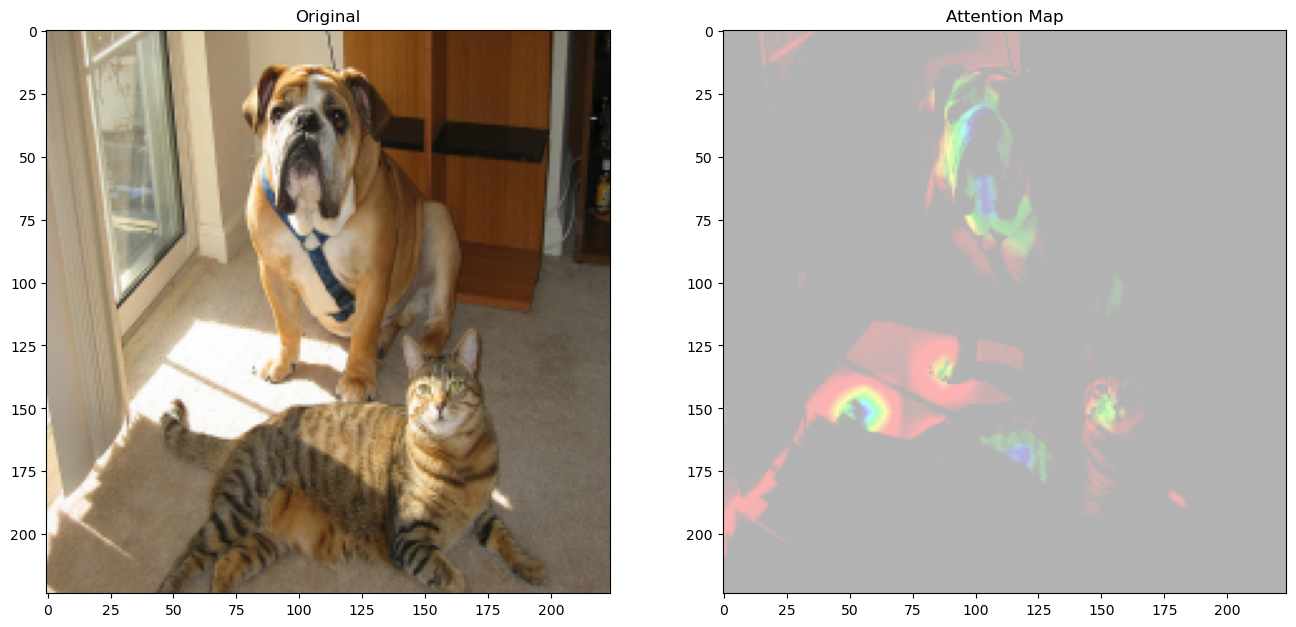

In [52]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "grad_attention_rollout" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/input.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

In [48]:
mask

array([[[0.53543307, 0.26377953, 0.2992126 ],
        [0.52755906, 0.25590551, 0.27952756],
        [0.52362205, 0.2519685 , 0.27952756],
        ...,
        [0.3503937 , 0.01574803, 0.01181102],
        [0.36220472, 0.02755906, 0.03149606],
        [0.37007874, 0.03543307, 0.04724409]],

       [[0.54724409, 0.26377953, 0.30314961],
        [0.53937008, 0.26377953, 0.29133858],
        [0.52755906, 0.2519685 , 0.28346457],
        ...,
        [0.35433071, 0.01574803, 0.01574803],
        [0.36220472, 0.02362205, 0.02755906],
        [0.38188976, 0.04724409, 0.05905512]],

       [[0.5511811 , 0.26771654, 0.30314961],
        [0.54330709, 0.26377953, 0.29133858],
        [0.53149606, 0.2519685 , 0.28346457],
        ...,
        [0.35433071, 0.01574803, 0.01574803],
        [0.37007874, 0.03149606, 0.03543307],
        [0.39370079, 0.05905512, 0.07086614]],

       ...,

       [[0.63385827, 0.41338583, 0.44488189],
        [0.50787402, 0.30708661, 0.33858268],
        [0.46456693, 0

In [47]:
mask.max()

1.0

In [45]:
mask.min()

1

In [27]:
output = model(input_tensor)

In [29]:
output.shape

torch.Size([1, 1000])

In [31]:
import requests
import torch.nn.functional as F

LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

scores = model(input_tensor)

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

_ = print_preds(scores)